In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Fearless-mode Champion Clustering
df = pd.read_csv(r'../data/raw/Worlds 2025 Main Event - Champion Stats - OraclesElixir.csv')


# ============================================
# Data Preprocessing
# ============================================

# Select relevant features for clustering
feature_cols =  ['P%', 'B%', 'W%', 'CTR%',  # pick rate, ban rate, win rate, counter pick rate
    'K', 'D', 'A', 'KDA', 'KP', # kills, deaths, assists, KDA ratio, kill participation
    'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10',  #share of team deaths, first blood rate, gold diff at 10 min, xp diff at 10 min, cs diff at 10 min
    'CSPM', 'CS%P15', #minion per minute, share of team total CS post 15min, 
    'DPM', 'DMG%', 'GOLD%', #damage to champions per min, damage share, gold share, 
    'WPM', 'WCPM'  # wards placed per min, ward cleared per min
]
feature_kda = ['K', 'D', 'A']
feature_cols_perc = [
    'P%', 'B%', 'W%', 'CTR%', 'KP','DTH%', 'FB%', 'CS%P15', 'DMG%', 'GOLD%']

# Create a copy for analysis
df_features = df[['Champion', 'Pos', 'GP'] + feature_cols].copy()

# Data cleaning
df_features[feature_cols] = df_features[feature_cols].fillna(0)
df_features = df_features[df_features['Pos'] != '-']
df_features[feature_cols_perc] = df_features[feature_cols_perc].apply(lambda x: x.str.rstrip('%').astype(float))
df_features[feature_cols] = df_features[feature_cols].astype(float)
# Normalize K/D/A by games played - convert to per-game averages
df_features[feature_kda] = df_features[feature_kda].div(df_features['GP'], axis=0)


# Separate by position for position-specific clustering
positions = df_features['Pos'].unique()
df_features.head()

,Champion,Pos,GP,P%,B%,W%,CTR%,K,D,A,...,GD10,XPD10,CSD10,CSPM,CS%P15,DPM,DMG%,GOLD%,WPM,WCPM
0,Aatrox,Top,5,6.3,2.5,60.0,100.0,3.400000,2.200000,6.000000,...,-108.0,180.0,-1.4,7.8,23.0,644.0,22.1,21.7,0.36,0.17
1,Ahri,Middle,1,1.3,2.5,100.0,100.0,6.000000,2.000000,7.000000,...,312.0,334.0,14.0,8.8,21.1,765.0,27.3,22.0,0.34,0.44
2,Akali,Middle,5,6.3,6.3,40.0,100.0,5.800000,3.000000,5.200000,...,-181.0,-128.0,-3.2,7.6,21.7,652.0,23.8,22.4,0.28,0.21
3,Alistar,Support,24,30.0,31.3,54.0,29.0,0.583333,4.291667,11.250000,...,-76.0,66.0,-0.2,0.9,1.7,179.0,6.6,9.3,1.86,0.31
4,Ambessa,Top,18,22.5,30.0,39.0,61.0,3.222222,3.666667,4.833333,...,-31.0,56.0,-0.9,7.9,24.5,656.0,24.0,21.9,0.29,0.17



Champion Archetype Clustering by in-game stats(All Positions)
Cluster optimization plot saved as '../Result/cluster_optimization.png'


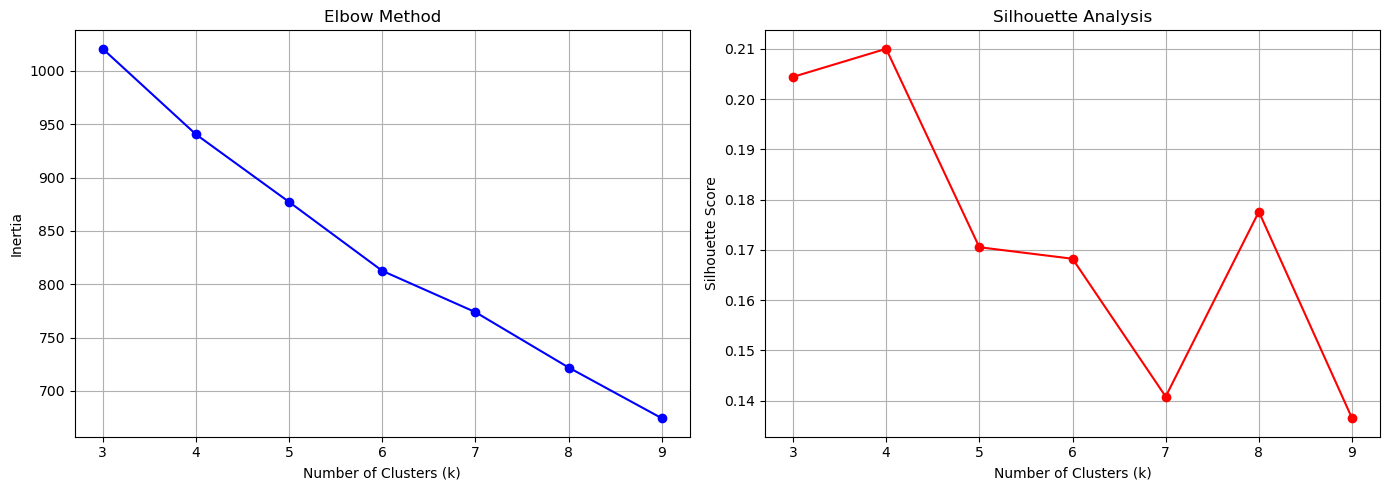

In [6]:
# ============================================
# Task 1: Overall Champion Clustering
# ============================================
import warnings
warnings.filterwarnings("ignore")
print("\n" + "="*60)
print("Champion Archetype Clustering by in-game stats(All Positions)")
print("="*60)

feature_stats =  [
    'K', 'D', 'A', 'KDA', 'KP', # kills, deaths, assists, KDA ratio, kill participation
    'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10',  #share of team deaths, first blood rate, gold diff at 10 min, xp diff at 10 min, cs diff at 10 min
    'CSPM', 'CS%P15', #minion per minute, share of team total CS post 15min, 
    'DPM', 'DMG%', 'GOLD%', #damage to champions per min, damage share, gold share, 
    'WPM', 'WCPM'  # wards placed per min, ward cleared per min
]

X = df_features[feature_stats].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K_range = range(3, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)

plt.tight_layout()
plt.savefig('../Result/cluster_optimization.png', dpi=300)
print("Cluster optimization plot saved as '../Result/cluster_optimization.png'")

In [7]:
# Use optimal k = 4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_features['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nUsing {optimal_k} clusters")
print(f"Silhouette Score: {silhouette_score(X_scaled, df_features['Cluster']):.3f}")

# Analyze each cluster
print("\n" + "-"*60)
print("CLUSTER ANALYSIS")
print("-"*60)

for cluster_id in range(optimal_k):
    cluster_champs = df_features[df_features['Cluster'] == cluster_id]
    print(f"\n=== CLUSTER {cluster_id} ({len(cluster_champs)} champions) ===")
    # list champions, if champion in multiple positions, list Champion(pos) in cluster
    print(f"Champions: {', '.join(cluster_champs.apply(lambda row: f'{row['Champion']}({row['Pos']})', axis=1).values)}")
    

    # Get cluster characteristics
    cluster_stats = cluster_champs[feature_stats].mean()
    print(f"\nKey characteristics:")
    print(f"  K/D/A: {cluster_stats['K']:.1f}/{cluster_stats['D']:.1f}/{cluster_stats['A']:.1f}")
    print(f"  Kill Participation: {cluster_stats['KP']:.1f}%")
    print(f"  Damage%: {cluster_stats['DMG%']:.1f}%")
    print(f"  Gold%: {cluster_stats['GOLD%']:.1f}%")
    print(f"  CS per Minute: {cluster_stats['CSPM']:.1f}")
    print(f"  First 10min Gold/XP/CS diff: {cluster_stats['GD10']:.0f} / {cluster_stats['XPD10']:.0f} / {cluster_stats['CSD10']:.0f}")

# Summary statistics by cluster
cluster_summary = df_features.groupby('Cluster')[feature_cols].agg({
    'P%': 'mean',
    'B%': 'mean',
    'W%': 'mean',
    'KDA': 'mean',
    'DMG%': 'mean',
    'GOLD%': 'mean',
    'CSPM': 'mean',
    'GD10': 'mean',
    'XPD10': 'mean',
    'CSD10': 'mean'
}).round(1)

print("\n" + "="*60)
print("CLUSTER SUMMARY")
print("="*60)
print(cluster_summary)



Using 4 clusters
Silhouette Score: 0.210

------------------------------------------------------------
CLUSTER ANALYSIS
------------------------------------------------------------

=== CLUSTER 0 (2 champions) ===
Champions: Jinx(ADC), Zeri(ADC)

Key characteristics:
  K/D/A: 8.0/1.0/9.5
  Kill Participation: 85.0%
  Damage%: 28.9%
  Gold%: 26.1%
  CS per Minute: 8.8
  First 10min Gold/XP/CS diff: -54 / -920 / -18

=== CLUSTER 1 (46 champions) ===
Champions: Aatrox(Top), Akali(Middle), Ambessa(Top), Anivia(Middle), Annie(Middle), Aurora(Middle), Aurora(Top), Azir(Middle), Camille(Top), Corki(ADC), Galio(Middle), Galio(Top), Gragas(Top), Ivern(Jungle), Jarvan IV(Jungle), Jax(Top), Jayce(Top), Jhin(ADC), K'Sante(Top), Kassadin(Middle), Kled(Top), Maokai(Jungle), Mordekaiser(Top), Naafiri(Jungle), Nocturne(Jungle), Ornn(Top), Pantheon(Jungle), Poppy(Jungle), Poppy(Top), Rek'Sai(Top), Rumble(Top), Sejuani(Jungle), Senna(ADC), Sion(Top), Sivir(ADC), Skarner(Jungle), Swain(Middle), Sylas(Mi

In [8]:
# ============================================
# Meta Tier Classification
# ============================================
print("\n" + "="*60)
print("Meta Tier Classification")
print("="*60)

# Define tiers based on presence and performance
def classify_tier(row):
    presence = row['P%'] + row['B%']
    winrate = row['W%']
    
    if presence >= 80 or (presence >= 50 and winrate >= 60):
        return 'S'
    elif presence >= 50 or (presence >= 30 and winrate >= 50):
        return 'A'
    elif presence >= 20 or (presence >= 10 and winrate >= 40):
        return 'B'
    else:
        return 'C'

df_features['Meta_Tier'] = df_features.apply(classify_tier, axis=1)

print("\nMeta Tier Distribution:")
print(df_features['Meta_Tier'].value_counts().sort_index())

for tier in ['S', 'A', 'B', 'C']:
    tier_champs = df_features[df_features['Meta_Tier'] == tier]['Champion'].values
    tier_pos = df_features[df_features['Meta_Tier'] == tier]['Pos'].values
    print(f"\n{tier}-Tier Champions ({len(tier_champs)}):")
    print(', '.join([f"{champ}({pos})" for champ, pos in zip(tier_champs, tier_pos)]))

# Save results
df_features.to_csv('../Result/champion_clusters_analysis.csv', index=False)
print("\n\nResults saved to 'champion_clusters_analysis.csv'")



Meta Tier Classification

Meta Tier Distribution:
Meta_Tier
A    14
B    33
C    48
S     7
Name: count, dtype: int64

S-Tier Champions (7):
Azir(Middle), Neeko(Support), Orianna(Middle), Poppy(Support), Poppy(Top), Sion(Top), Yunara(ADC)

A-Tier Champions (14):
Alistar(Support), Ambessa(Top), Bard(Support), Braum(Support), Corki(ADC), Ezreal(ADC), Jarvan IV(Jungle), Poppy(Jungle), Qiyana(Jungle), Rumble(Top), Taliyah(Middle), Trundle(Jungle), Wukong(Jungle), Xin Zhao(Jungle)

B-Tier Champions (33):
Akali(Middle), Aurora(Middle), Aurora(Top), Caitlyn(ADC), Cassiopeia(Middle), Draven(ADC), Galio(Middle), Galio(Top), Jax(Top), Jhin(ADC), K'Sante(Top), Kai'Sa(ADC), Karma(Support), LeBlanc(Middle), Leona(Support), Lucian(ADC), Nautilus(Support), Ornn(Top), Pantheon(Jungle), Rakan(Support), Rek'Sai(Top), Rell(Support), Renata Glasc(Support), Renekton(Top), Ryze(Middle), Sivir(ADC), Varus(ADC), Vi(Jungle), Viktor(Middle), Xayah(ADC), Yone(Middle), Ziggs(ADC), Ziggs(Middle)

C-Tier Champions